# XGBoost2GPU Example

Este notebook demonstra como usar a classe `XGBoost2GPU` para gerar código CUDA a partir de modelos XGBoost treinados com TreeLUT.

## Importações e Configuração do Ambiente

In [19]:
import sys
import os
from pathlib import Path



# Importações principais
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from LoadDataset import LoadDataset
from treelut import TreeLUTClassifier

from xgboost2gpu import XGBoost2GPU


ModuleNotFoundError: No module named 'xgboost2gpu'

## Parâmetros do Modelo

In [9]:
# Parâmetros para o XGBoost
xgb_params = {
    'objective': 'multi:softmax', 
    'num_class': 2, 
    'n_estimators':7, 
    'max_depth': 7, 
    'eta': 0.8
}

# Parâmetros para o TreeLUT
treelut_params = {
    'w_feature': 2, 
    'w_tree': 2,
    'bits_features': 16,
    'pipeline': [0, 0, 0], 
    'dir_path': './OutputFiles/MakeDataset/',
    'style': 'mux',
    'argmax': True,
    'quantized': True
}

# Parâmetros para o make_classification
make_classification_params = {
    'n_samples': 50000, 
    'n_features': 54, 
    'n_informative': 6, 
    'n_redundant': 30, 
    'n_classes': xgb_params['num_class'], 
    'random_state': 42
}

# Parâmetros para o XGBoost2GPU
xgb2gpu_params = {
    'percentage_to_cut': 0.10,
    'strategy': 'adaptive',
    'level_importance': 0.5,
    'progress_importance': 0.7,
    'level_bias': 1.0,
    'max_cut_percentage': 0.2,
    'urgency_override_threshold': 1.5,
    'output_file': 'prune.csv',
}

## Carregamento e Preparação dos Dados

Vamos usar um dataset sintético para demonstração. Em um cenário real, você pode usar qualquer dataset de classificação.

In [10]:
# Gerar dados sintéticos para demonstração
from sklearn.datasets import make_classification

# Criar dataset sintético
X, y = make_classification(**make_classification_params)

# Load Covtype dataset
susy = pd.read_csv('../data/SUSY_int.csv')
data = susy.drop(columns=['target'])
target = susy['target'].astype('int')


# Transformar os dados para inteiros positivos
# X = (X * 1000).astype(np.int32)  # Multiplicar por 1000 para evitar valores negativos



# Converter para DataFrame para facilitar manipulação
# data = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
# target = pd.Series(y, name='target')

print(f"Dataset shape: {data.shape}")
print(f"Classes: {np.unique(y)}")
print(f"Class distribution: {np.bincount(y)}")
print(f"First 5 rows of data:\n{data.head()}")

Dataset shape: (4999999, 18)
Classes: [0 1]
Class distribution: [24990 25010]
First 5 rows of data:
        0        1        2        3        4        5        6        7  \
0  377584  1667973    64191 -1225171   506102  -338939  1672543  3475464   
1  180910   444840  -134298  -709972   451719 -1613871  -768661  1219918   
2   90719   381256  -976145   693152   448959   891753  -677328  2033059   
3   94859  1309996  -690089  -676259  1589283  -693326   622907  1087562   
4  186044   456398  1099371  1512453   751772   638967  -742216   322601   

         8        9       10       11       12       13       14       15  \
0 -1219136    12955  3775174  1045976   568051   481928        0   448410   
1   504026  1831248  -431385   526283   941514  1587535  2024308   603498   
2  1533041  3046260 -1005285   569386  1015211  1582217  1551914   761215   
3  -381742   589204  1365479  1179295   968218   728563        0  1083158   
4  1321054   169502   359941   489256   416168   754829   

In [11]:


# Converter para uint8 para compatibilidade
data_un = data.astype('int32')
data_un = data_un.astype('uint16')


X_train, X_test, y_train, y_test = train_test_split(
    data_un, target, test_size=0.2, random_state=42
)

# Obter valores máximos e mínimos para quantização
max_values = X_test.max().astype('uint16').to_numpy()
min_values = X_test.min().astype('uint16').to_numpy()

print("Valores máximos por feature:")
print(max_values)
print("\nValores mínimos por feature:")
print(min_values)

Valores máximos por feature:
[65535 65535 65535 65535 65535 65535 65535 65535 65535 65535 65535 65535
 65535 65535 65535 65535 65535 65535]

Valores mínimos por feature:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


## Quantização dos Dados

In [12]:
# Aplicar normalização Min-Max
scaler = MinMaxScaler()
w_feature_treelut = treelut_params['w_feature']

X_train_min_max = np.round(scaler.fit_transform(X_train) * (2**w_feature_treelut - 1))
X_test_min_max = np.clip(
    np.round(scaler.transform(X_test) * (2**w_feature_treelut - 1)), 
    0, 2**w_feature_treelut - 1
)

# Quantização simples usando operação bit-wise
X_train_quantized = np.array(X_train, dtype=np.int32) & (2**w_feature_treelut - 1)
X_test_quantized = np.array(X_test, dtype=np.int32) & (2**w_feature_treelut - 1)

print(f"Dados originais shape: {X_train.shape}")
print(f"Dados quantizados shape: {X_train_quantized.shape}")

Dados originais shape: (3999999, 18)
Dados quantizados shape: (3999999, 18)


## Treinamento do Modelo XGBoost

In [13]:
# Treinar modelo XGBoost com dados quantizados
xgb_clf = XGBClassifier(**xgb_params)
xgb_clf.fit(X_train_quantized, y_train)
y_pred_xgb = xgb_clf.predict(X_test_quantized)
print(f"Acurácia XGBoost (dados quantizados): {accuracy_score(y_pred_xgb, y_test):.3f}")

# Treinar modelo XGBoost com dados originais para comparação
xgb_clf_original = XGBClassifier(**xgb_params)
xgb_clf_original.fit(X_train, y_train)
y_pred_xgb_original = xgb_clf_original.predict(X_test)
print(f"Acurácia XGBoost (dados originais): {accuracy_score(y_pred_xgb_original, y_test):.3f}")

# Treinar modelo XGBoost com dados min-max normalizados
xgb_clf_min_max = XGBClassifier(**xgb_params)
xgb_clf_min_max.fit(X_train_min_max, y_train)
y_pred_xgb_min_max = xgb_clf_min_max.predict(X_test_min_max)
print(f"Acurácia XGBoost (min-max): {accuracy_score(y_pred_xgb_min_max, y_test):.3f}")

Acurácia XGBoost (dados quantizados): 0.541
Acurácia XGBoost (dados originais): 0.575
Acurácia XGBoost (min-max): 0.558


## Conversão para TreeLUT

In [14]:
# Escolher dados de teste baseado nos parâmetros do TreeLUT
treelut_X_test = X_test if treelut_params['quantized'] else X_test_quantized

# Criar e converter modelo TreeLUT
treelut_clf = TreeLUTClassifier(
    xgb_model=xgb_clf_min_max, 
    **treelut_params, 
    min=min_values, 
    max=max_values
)

treelut_clf.convert()
y_pred_treelut = treelut_clf.predict(X_test_min_max)
print(f"Acurácia TreeLUT: {accuracy_score(y_pred_treelut, y_test):.3f}")

# Save verilog
treelut_clf.verilog()
treelut_clf.testbench(treelut_X_test, y_test)

# Mostrar informações sobre as árvores
print(f"\nNúmero de árvores: {len(treelut_clf.trees)}")
print(f"Número total de nós: {sum(treelut_clf.nodes())}")
print(f"Número de nós por árvore: {treelut_clf.nodes()}")
print(f"Número de classes: {treelut_clf.n_classes}")

Acurácia TreeLUT: 0.507

Número de árvores: 14
Número total de nós: 3570
Número de nós por árvore: [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255]
Número de classes: 2


## Geração de Código CUDA com XGBoost2GPU

In [15]:
# Criar instância do XGBoost2GPU
xgb2gpu = XGBoost2GPU(treelut_model=treelut_clf, 
                      w_feature=treelut_params['w_feature'],
                      w_tree=treelut_params['w_tree'], 
                      n_samples=X_test.shape[0])

# Definir arquivo de saída
output_file = f"xgboost_cuda_generated.cu"

# Gerar código CUDA
xgb2gpu.generate_cuda_code(output_file)
print(f"✅ Código CUDA gerado com sucesso em: {output_file}")

# Calcular e salvar probabilidades de corte
xgb2gpu.calculate_forest_probabilities(**xgb2gpu_params)
print("✅ Probabilidades de corte calculadas e salvas em prune.csv")


NameError: name 'XGBoost2GPU' is not defined

### Análise de Probabilidades de Corte

In [ ]:
prune_matrix = xgb2gpu.prune_matrix(num_threads=1000, save_matrix=True)
unique_rows, counts = np.unique(prune_matrix, axis=0, return_counts=True)

print(f"Total de amostras: {len(prune_matrix)}")
print(f"Padrões únicos: {len(unique_rows)}")
print(f"Padrões que se repetem: {len(counts[counts > 1])}")
print(f"Maior repetição: {max(counts)}")

# Valor de 0 e 1 de cada linha
print("Valores de 0 e 1 de cada linha:")
num_1s = []
num_0s = []
for row in prune_matrix:
    num_1s.append(np.sum(row))
    num_0s.append(len(row) - np.sum(row))
print(f"Número médio de 1s: {np.mean(num_1s):.3f}")
print(f"Número médio de 0s: {np.mean(num_0s):.3f}")

Prune matrix saved to 'prune_matrix.csv'.
Total de amostras: 1000
Padrões únicos: 1000
Padrões que se repetem: 0
Maior repetição: 1
Valores de 0 e 1 de cada linha:
Número médio de 1s: 1562.903
Número médio de 0s: 2007.097


In [ ]:
# Salvar X_test em um arquivo CSV
def save_test_data_to_csv(X_test, file_path):
    try:
        # Drop header and index to match the expected format
        if isinstance(X_test, pd.DataFrame):
            X_test = X_test.values  # Convert DataFrame to numpy array if needed
            # Drop header
        elif isinstance(X_test, pd.Series):
            X_test = X_test.values.reshape(-1, 1)  # Convert Series to 2D array
        elif not isinstance(X_test, np.ndarray):
            raise ValueError("X_test deve ser um DataFrame ou um numpy array.")
        # Save to CSV
        df = pd.DataFrame(X_test)
        df.to_csv(file_path, index=False, header=False)
        print(f"✅ Dados de teste salvos em: {file_path}")
    except Exception as e:
        print(f"❌ Erro ao salvar os dados de teste: {e}")
save_test_data_to_csv(X_test, "input.csv")
save_test_data_to_csv(y_test, "expected_output.csv")

✅ Dados de teste salvos em: input.csv
✅ Dados de teste salvos em: expected_output.csv


## Próximos Passos

Para usar o código CUDA gerado:

1. **Compilação**: Compile o arquivo `.cu` usando `nvcc`
2. **Dados de entrada**: Prepare arquivos CSV com os dados de teste:
   - `input.csv`: Dados de entrada para inferência
   - `expected_output.csv`: Rótulos esperados para validação
   - `prune.csv`: Vetor de poda para controlar quais nós usar
3. **Execução**: Execute o programa CUDA compilado
4. **Análise**: Verifique a acurácia e performance

### Exemplo de compilação:
```bash
nvcc -o xgboost_gpu xgboost_cuda_generated.cu
./xgboost_gpu
```

### Visualização de Importâncias

Plotando 7 árvores por classe, para 2 classes.


/tmp/ipykernel_43024/3519848543.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab10')


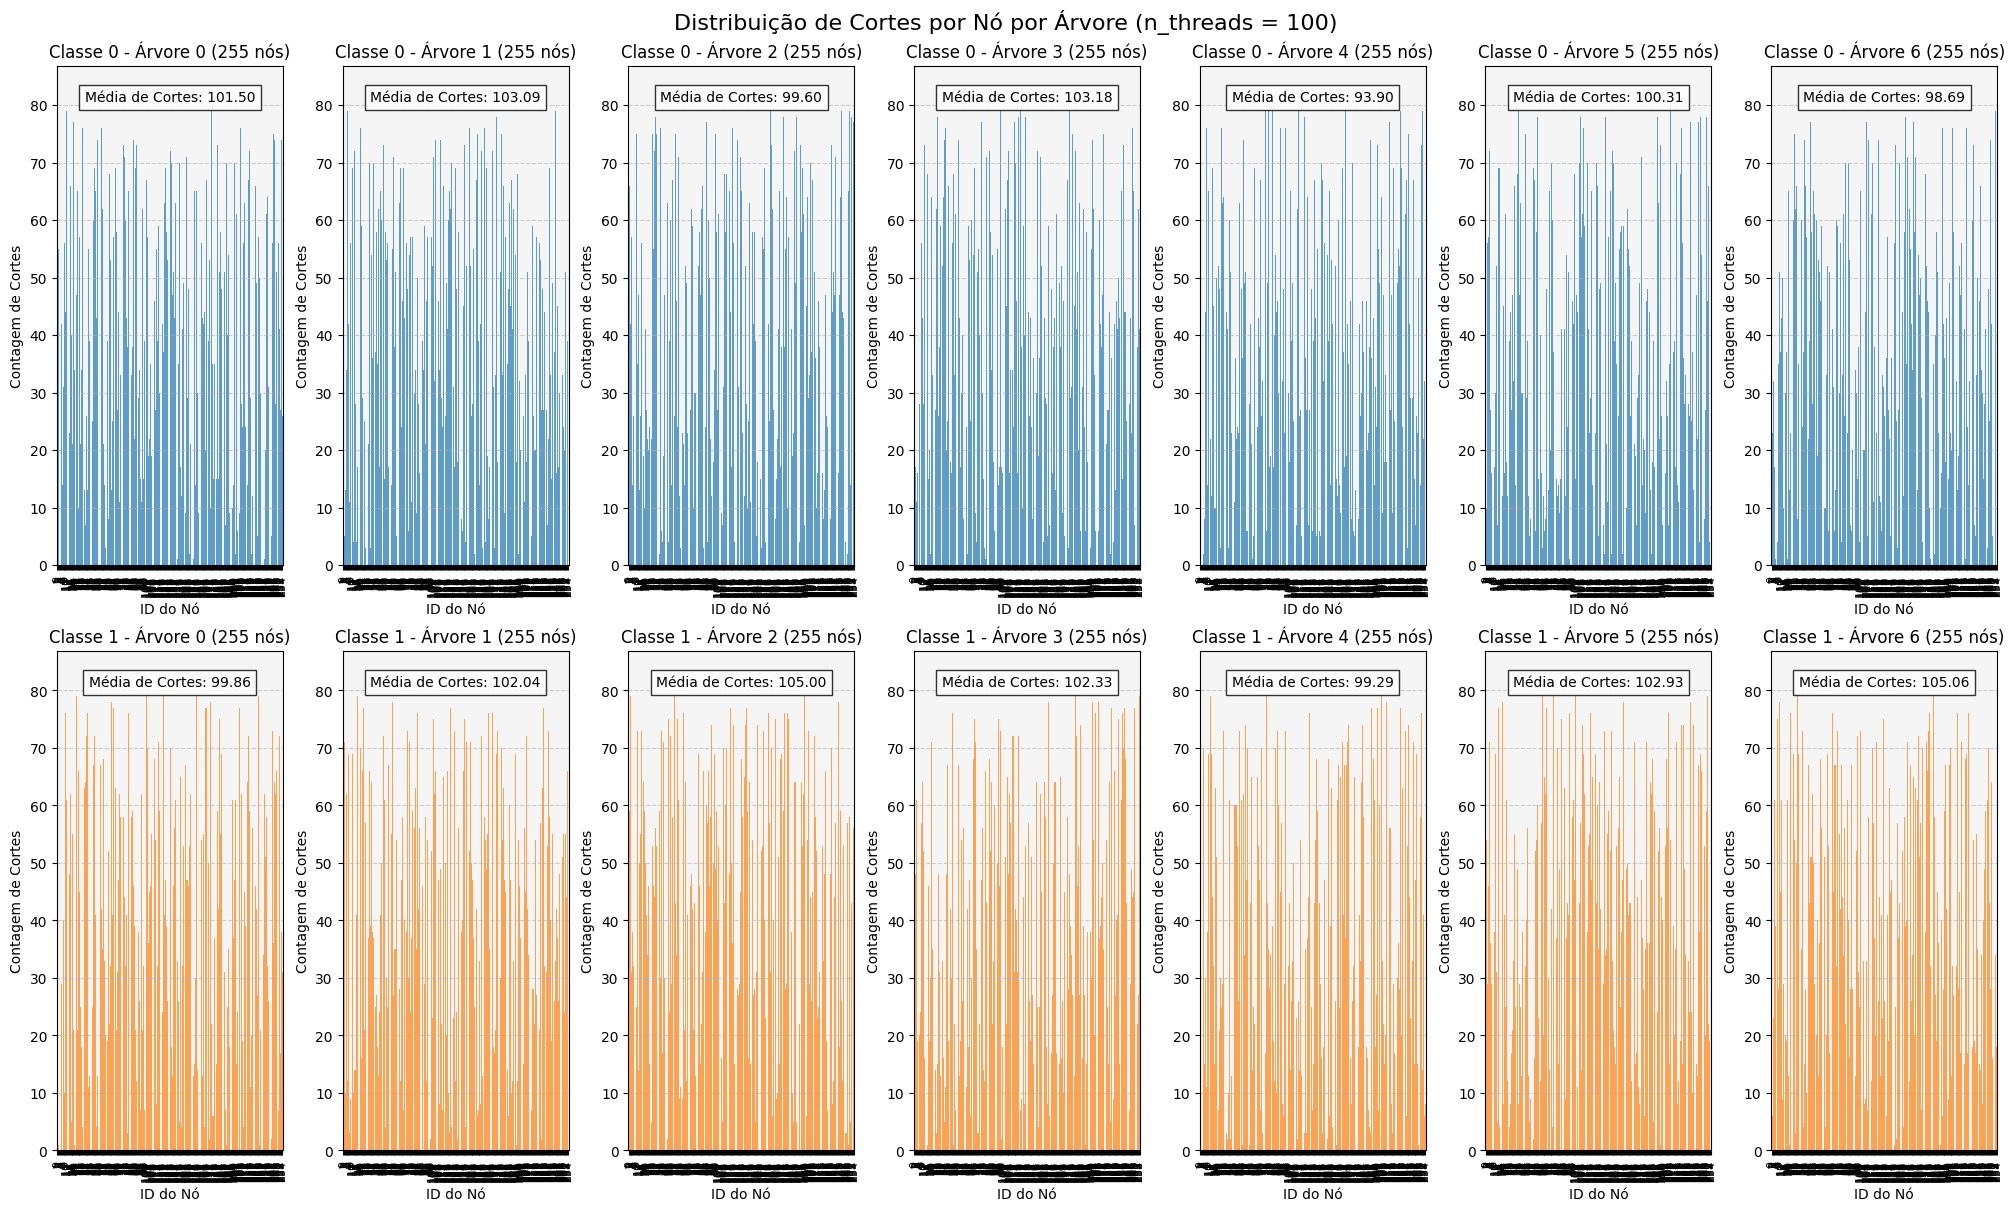

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap

def save_trees_to_file(trees, filename='trees.txt'):
    with open(filename, 'w') as f:
        f.write(str(trees))
    print(f"Árvores salvas em {filename}")

def plot_tree_cut_distribution(trees, num_threads=1000, num_classes=3, num_trees_per_class=4):
    """
    Plota a distribuição de cortes dos nós para um conjunto de árvores,
    com as classes nas linhas e as árvores nas colunas.
    """
    if not trees:
        print("Nenhuma árvore para plotar.")
        return

    # Configuração do layout dos subplots (CLASSES x ÁRVORES)
    fig, axes = plt.subplots(
                            nrows=num_classes,
                            ncols=num_trees_per_class,
                            figsize=(20, 12),
                            squeeze=False,
                            constrained_layout=True)

    print(f"Plotando {num_trees_per_class} árvores por classe, para {num_classes} classes.")
    fig.suptitle(f'Distribuição de Cortes por Nó por Árvore (n_threads = {num_threads})', fontsize=16)

    # Paleta de cores por classe
    cmap = get_cmap('tab10')
    class_colors = [cmap(i) for i in range(num_classes)]

    # Loop principal para plotar cada árvore em sua posição correta na grade
    for class_idx in range(num_classes):
        for tree_idx in range(num_trees_per_class):
            # Calcula o índice da árvore na lista de dados
            # (Ex: Árvore 0 da Classe 1 -> 1 + 0*3 = índice 1)
            # (Ex: Árvore 1 da Classe 0 -> 0 + 1*3 = índice 3)
            list_key = class_idx + tree_idx * num_classes
            
            # Pega o subplot correspondente
            ax = axes[class_idx, tree_idx]

            # Verifica se a árvore existe nos dados carregados
            if list_key >= len(trees):
                ax.set_title(f'Classe {class_idx} - Árvore {tree_idx} (Ausente)')
                ax.axis('off')
                continue

            tree = trees[list_key]

            # Prepara dados para plotagem
            nodes = sorted(tree.keys())
            cut_counts = simulate_cuts(tree, num_threads)
            total_cuts_mean = sum(cut_counts.values()) / num_threads if num_threads > 0 else 0

            # Plotagem das barras
            ax.bar(nodes, [cut_counts.get(node, 0) for node in nodes],
                   color=class_colors[class_idx], alpha=0.7)

            # Customização do gráfico
            ax.set_title(f'Classe {class_idx} - Árvore {tree_idx} ({len(nodes)} nós)')
            ax.set_xlabel('ID do Nó')
            ax.set_ylabel('Contagem de Cortes')
            if nodes:
                ax.set_xticks(nodes)
                ax.tick_params(axis='x', rotation=90, labelsize=8) # Rotaciona para melhor visualização
                ax.set_xlim(min(nodes) - 0.5, max(nodes) + 0.5)

            # Adiciona rótulo com a média de cortes
            total_cuts_label = f'Média de Cortes: {total_cuts_mean:.2f}'
            ax.text(0.5, 0.95, total_cuts_label, transform=ax.transAxes,
                    fontsize=10, ha='center', va='top', bbox=dict(facecolor='white', alpha=0.8))

            ax.set_ylim(0, max(cut_counts.values()) * 1.1 if cut_counts else 1)
            ax.set_facecolor('whitesmoke')
            ax.grid(axis='y', linestyle='--', alpha=0.6)

    plt.show()

def simulate_cuts(tree, num_threads):
    """
    Função de simulação para gerar contagens de cortes aleatórias para cada nó.
    """
    cut_counts = {node: 0 for node in tree.keys()}
    for node in tree.keys():
        # Gera um valor aleatório para simular a contagem de cortes
        cut_counts[node] = np.random.randint(0, num_threads * 0.8)
    return cut_counts

trees_data = xgb2gpu.model.trees
plot_tree_cut_distribution(trees_data, num_threads=100, 
                           num_classes=xgb_params['num_class'], 
                           num_trees_per_class=xgb_params['n_estimators'])

0
3570


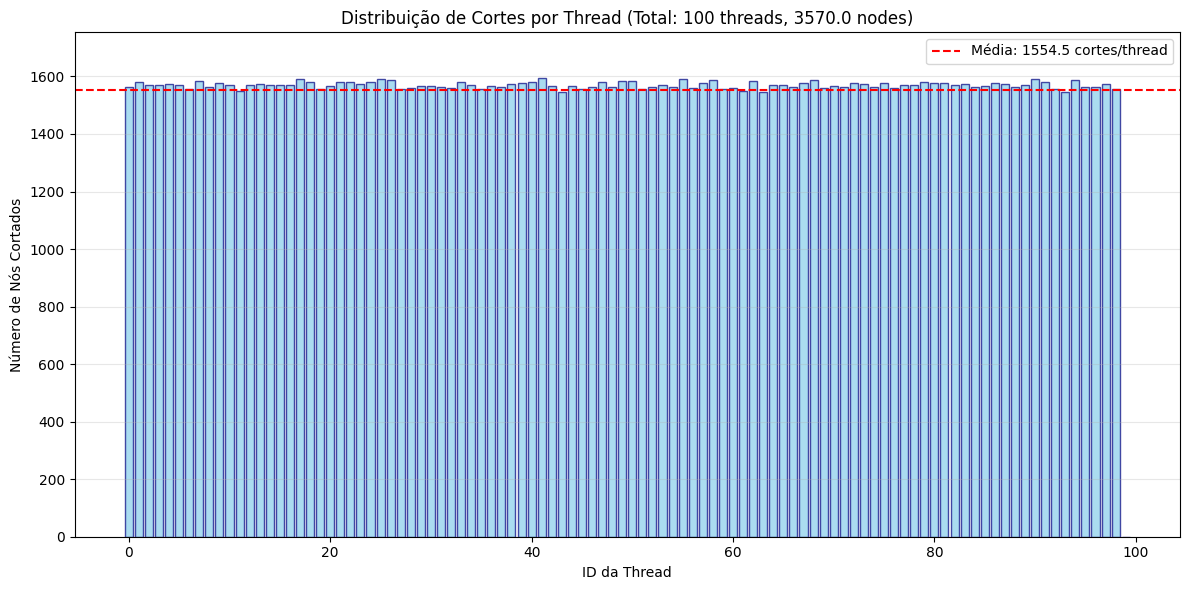

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def plot_cuts_per_thread(trees, num_threads=1000, num_classes=3):
    # Dicionário para armazenar cortes por thread
    thread_cuts = defaultdict(int)
    num_nodes = defaultdict(int)

    # Simulação: para cada thread, conta quantos nós foram cortados
    for thread_id in range(num_threads):
        if thread_id == 0: continue
        for tree in trees:
            for node, value in tree.items():
                if xgb2gpu.should_cut_node(thread_id, value['global_id']):
                    thread_cuts[thread_id] += 1
                num_nodes[thread_id] += 1

    print(thread_cuts[0])
    print(num_nodes[1])

    mean_nodes = np.mean(list(num_nodes.values())) if num_nodes else 0

    # Prepara dados para plotagem
    cuts_count = [count for count in thread_cuts.values()]
    threads = range(num_threads)
    
    # Configuração do plot
    plt.figure(figsize=(12, 6))
    bars = plt.bar(threads, cuts_count, color='skyblue', edgecolor='navy', alpha=0.7)
    
    # Linha de média
    mean_cuts = np.mean(cuts_count)
    plt.axhline(mean_cuts, color='red', linestyle='--', 
                label=f'Média: {mean_cuts:.1f} cortes/thread')
    
    # Customização
    plt.title(f'Distribuição de Cortes por Thread (Total: {num_threads} threads, {mean_nodes:.1f} nodes)')
    plt.xlabel('ID da Thread')
    plt.ylabel('Número de Nós Cortados')
    plt.grid(axis='y', alpha=0.3)
    plt.legend()
    
    # Ajusta eixos para melhor visualização
    max_cuts = max(cuts_count) if cuts_count else 0
    plt.ylim(0, max_cuts * 1.1)
    
    plt.tight_layout()
    plt.show()

trees_data = xgb2gpu.model.trees

plot_cuts_per_thread(trees_data, num_threads=100, num_classes=xgb_params['num_class'])


### Rodar cuda

In [ ]:
! nvcc -arch=sm_89 -O3 -lineinfo -o xgboost_cuda_generated xgboost_cuda_generated.cu -O3 -Wno-deprecated-gpu-targets

xgboost_cuda_generated.cu(3864): warning #61-D: integer operation result is out of range
      cudaMemcpy(Y_host, Y, totalThreads * sample_size * sizeof(int), cudaMemcpyDeviceToHost);
                                         ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

xgboost_cuda_generated.cu(3864): warning #68-D: integer conversion resulted in a change of sign
      cudaMemcpy(Y_host, Y, totalThreads * sample_size * sizeof(int), cudaMemcpyDeviceToHost);
                            ^

xgboost_cuda_generated.cu(3869): warning #61-D: integer operation result is out of range
      for (int i = 0; i < totalThreads*sample_size; i++) {
                                      ^

xgboost_cuda_generated.cu(3864): warning #61-D: integer operation result is out of range
      cudaMemcpy(Y_host, Y, totalThreads * sample_size * sizeof(int), cudaMemcpyDeviceToHost);
                                         ^

Remark: The warnings can be suppressed with "-diag-sup

In [ ]:
! ./xgboost_cuda_generated


^C
